In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk
import csv
import spacy
import locationtagger


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score

### PubMed data obtained 11/4/22

In [2]:
data = open("pm3.txt", "r", encoding="utf8")
file_content = data.read()

content_list = file_content.split("\n\n")
data.close()

In [3]:
len(content_list)

1260

In [4]:
df = pd.DataFrame(columns=['Date', 'Country', 'Continent','Title', 'Abstract'])

## Add location

In [5]:
for i in range(len(content_list)):
    s = content_list[i]
    start = 'AD'
    location = (s[s.find(start)+(len(start)+4):s.find(start)+(len(start)+200)])
    df.loc[i, 'Country']= location

In [6]:
loc_list=(df['Country'].to_list())

In [7]:
for i in range(len(loc_list)):
    place_entity = locationtagger.find_locations(text = loc_list[i])
    countries = place_entity.other_countries
    if len(countries) > 0:
        df.loc[i, 'Country']= place_entity.other_countries[0]
    else:
        df.loc[i, 'Country']= np.nan 

In [8]:
import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [9]:
for i in range(len(df)):
    if type(df.iloc[i]['Country']) != float:
        df.loc[i, 'Continent']= country_to_continent(df.iloc[i]['Country'])

In [10]:
df.head(5)

,Date,Country,Continent,Title,Abstract
0,NaN,Viet Nam,Asia,NaN,NaN
1,NaN,United States,North America,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,France,Europe,NaN,NaN
4,NaN,Hong Kong,Asia,NaN,NaN


In [11]:
df3 = df[df['Country'].notna()]
print ("Full data set:", len(df) ,"articles")
print ("Articles with country data:", len(df3))

Full data set: 1260 articles
Articles with country data: 1118


In [1]:
results = df3.groupby('Country').size().sort_values(ascending=False)
results.head(10)

NameError: name 'df3' is not defined

In [13]:
print ("The number of unique countries:", len(pd.unique(df3['Country'])))

The number of unique countries: 75


## Add article titles and dates

In [14]:
for i in range(len(content_list)):
    s = content_list[i]
    start = 'EDAT'
    date = (s[s.find(start)+(len(start)+2):s.find(start)+(len(start)+12)])
    df.loc[i, 'Date']= date
    
    start = 'TI'
    end = 'LID'
    title = (s[s.find(start)+(len(start)+3):s.find(end)])
    
    end = 'PG'
    title = (title[:title.find(end)]).strip()
    title = re.sub(r'\n', '', title)
    title = re.sub(r'[ ]{2,}', ' ', title)
    df.loc[i, 'Title']= title
    

#### Convert dates to datetime objects, fix corrupted dates

In [15]:
from datetime import  datetime
format = '%Y/%m/%d'
for i in range(len(df)):
    df.loc[i,'Date'] = datetime.strptime(df.loc[i,'Date'], format)

In [16]:
for i in range(len(df)):
    s = content_list[i]
    if df.loc[i,'Date'] < datetime(2020, 2, 1, 0, 0):
        df.loc[i,'Date'] = (s[s.find('PHST')+(6):s.find('PHST')+(16)])
        df.loc[i,'Date'] = datetime.strptime(df.loc[i,'Date'], format)

## Add abstracts to the dataframe, strip new lines and extra spaces

In [17]:
for i in range(len(content_list)):
    s = content_list[i].strip()
    start = 'AB'
    end = 'FAU'
    end2 = 'CI'
    end3 = 'TRIAL REGISTRATION'
    
    if 'AB  -' in s:
        abst = (s[s.find(start)+(len(start)+3):s.find(end)])
        abst = ((abst[:abst.find(end2)]))
        abst = ((abst[:abst.find(end3)]))
        abst = re.sub(r'\n', '', abst)
        abst = re.sub(r'[ ]{2,}', ' ', abst)
    
        #remove digits
        #abst = re.sub(r'\d+', '', abst)
    
        abst = abst.strip()
        df.loc[i, 'Abstract']= abst
    
    else:
        df.loc[i, 'Abstract']= np.nan
    

In [18]:
df2 = df.dropna(subset=['Abstract']).copy()
df2.reset_index(drop=True, inplace=True)
print ("Full data set:", len(df) ,"articles")
print ("Articles with abstracts:", len(df2) ,"articles")

Full data set: 1260 articles
Articles with abstracts: 890 articles


In [19]:
wordcount = 0
for i in range(len(df2)):
    wordcount += len((df2.loc[i]["Abstract"]).split())
    
print("Total wordcount from",len(df2),"abstracts:", wordcount)
print("Average words per article:", wordcount/len(df2))

Total wordcount from 890 abstracts: 176224
Average words per article: 198.00449438202247


## Graph cumulative articles over time 

In [22]:
pubdates= df['Date'].tolist()

In [24]:
sorted_dates = sorted(pubdates)
print ('First publication date:', sorted_dates[0])
print ('Last publication date:', sorted_dates[-1])

First publication date: 2020-02-23 00:00:00
Last publication date: 2022-11-05 00:00:00


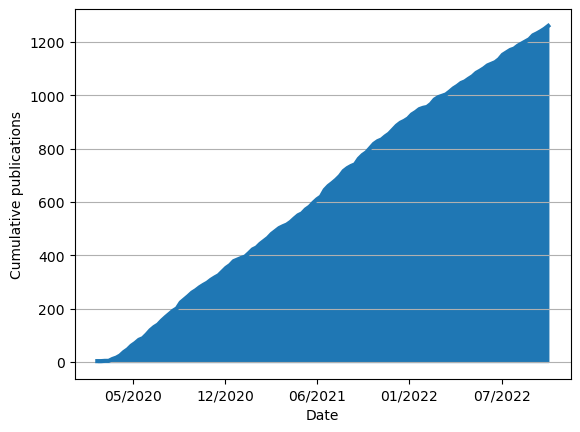

In [57]:
from matplotlib.dates import date2num, num2date
from matplotlib import ticker
from matplotlib import pyplot as plt

num_dates = [date2num(d) for d in pubdates]
histo = np.histogram(num_dates, bins=120)
cumulative_histo_counts = histo[0].cumsum()

fig, ax = plt.subplots()
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: num2date(x).strftime('%m/%Y')))
plt.plot(histo[1][1:], cumulative_histo_counts, linewidth=3)
plt.style.use('default')
ax.grid(axis='y')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.xlabel("Date")
plt.ylabel("Cumulative publications")
plt.fill_between(histo[1][1:], cumulative_histo_counts, color='#1f77b4')
plt.show()


## TF-IDF

In [27]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom = list(ENGLISH_STOP_WORDS)
new_words = ['covid','sars', 'cov','introduction','background', 'lessons', 'learned', 'pandemic', 'health']
custom += new_words

### Text Blob stemmer and tokenizer

In [28]:
from textblob import TextBlob

def textblob_tokenizer(str_input):
    str_input = re.sub(r'\d+', '', str_input)
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [29]:
stop_tokens=[]
for i in custom:
    blob = TextBlob(i)
    tokens = blob.words
    stemmed = [token.stem() for token in tokens]
    stop_tokens.append(stemmed[0])

In [32]:
tfidf = TfidfVectorizer(stop_words= stop_tokens, tokenizer=textblob_tokenizer)
data = tfidf.fit_transform((df2['Abstract']))
tokens = tfidf.get_feature_names()
#tokens

C:\Users\ts004\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


## Kmeans


In [33]:
from sklearn.cluster import KMeans

number_of_clusters=8

km = KMeans(n_clusters=number_of_clusters,random_state=1)

km.fit(data)

KMeans(random_state=1)

In [37]:
df2['Labels']=km.labels_

In [38]:
a = km.labels_
unique, counts = np.unique(a, return_counts=True)

result = dict(zip(unique, counts))
print ("Counts per cluster \n")
for i,j in result.items():
    print("Cluster",i,": ",j)
    

Counts per cluster 

Cluster 0 :  64
Cluster 1 :  46
Cluster 2 :  156
Cluster 3 :  45
Cluster 4 :  90
Cluster 5 :  273
Cluster 6 :  119
Cluster 7 :  97


In [39]:
num_words=5

print("Top", num_words, "terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tokens

for i in range(number_of_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :num_words]]
    print("Cluster {}: {}".format(i, ' '.join(top_words)))

Top 5 terms per cluster:
Cluster 0: resid program educ train surgic
Cluster 1: student educ onlin cours univers
Cluster 2: infect diseas sars-cov patient coronaviru
Cluster 3: vaccin develop hesit campaign rate
Cluster 4: public respons countri outbreak control
Cluster 5: research commun use trial respons
Cluster 6: care patient telemedicin cancer visit
Cluster 7: patient p hospit surgeri period


## Explore clusters

In [40]:
def get_titles (cluster):
    pd.set_option('display.max_colwidth', -1)
    pd.set_option('display.max_rows', None)
    print( df2[df2['Labels']==cluster]["Title"])

In [41]:
def get_abstracts(cluster):
    pd.set_option('display.max_colwidth', -1)
    pd.set_option('display.max_rows', None)
    print(df2[df2['Labels']==cluster]['Abstract'])

In [42]:
cluster_to_explore = 4

print("Cluster", cluster_to_explore,"Titles \n")
get_titles (cluster_to_explore)
print("-------------------------------------------------------")
print("Cluster", cluster_to_explore,"Abstracts\n")
get_abstracts (cluster_to_explore)       

Cluster 4 Titles 

0      The first community outbreak of COVID-19 in Viet Nam: description and lessons learned.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

<ipython-input-40-fb423a8a028e>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
<ipython-input-41-2a4d22a3c79d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## word cloud

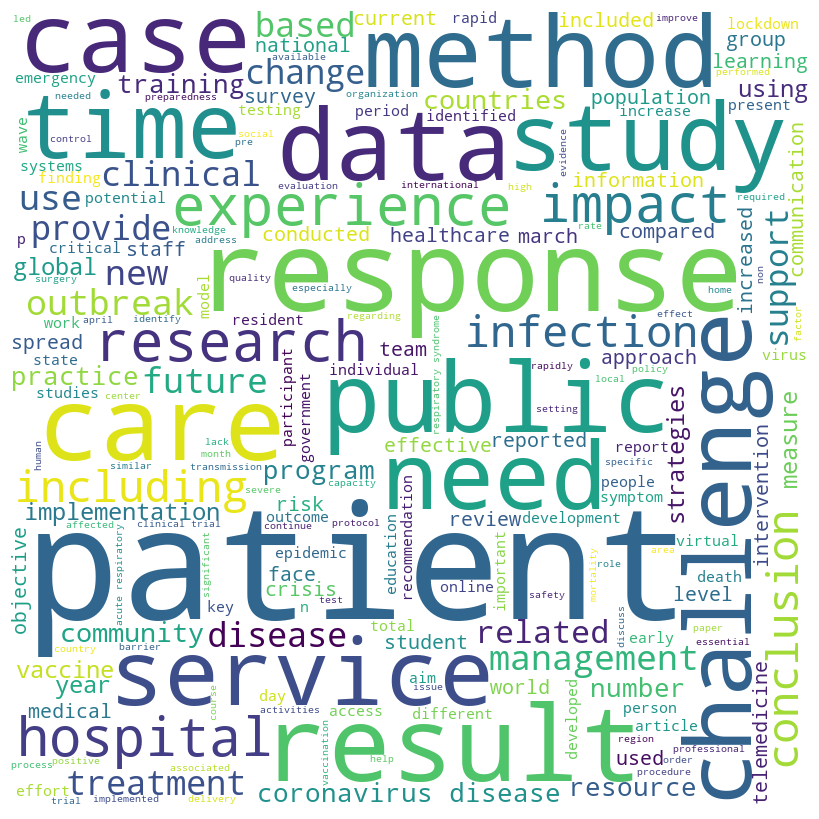

In [45]:
from wordcloud import WordCloud, STOPWORDS
 
comment_words = ''
stopwords = set(STOPWORDS)
import matplotlib.pyplot as plt
 
# iterate through abstracts
for val in df2['Abstract']:
 
    # split the abstracts into words
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = custom,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()